In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [26]:
import os
from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.image as mpimg
folder = r'C:\Users\HP Probook\Documents\Programming files\Python codes\ML\datasets\samples\\'



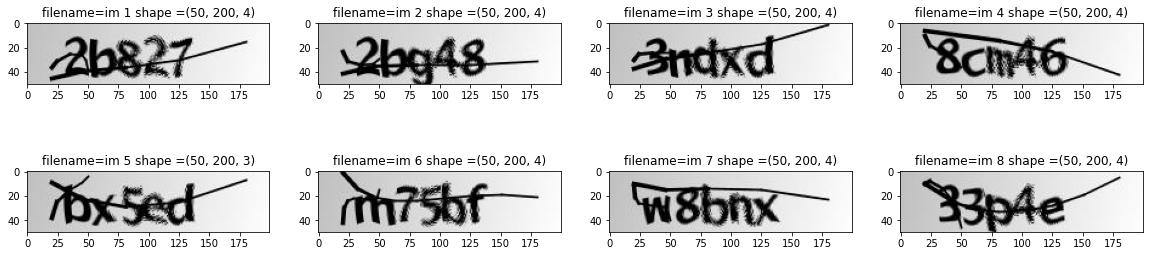

In [8]:
im_1 = mpimg.imread(folder + '2b827.png')
im_2 = mpimg.imread(folder + '2bg48.png')
im_3 = mpimg.imread(folder + '3ndxd.png')
im_4 = mpimg.imread(folder + '8cm46.png')
im_5 = mpimg.imread(folder + 'bx5ed.jpg')
im_6 = mpimg.imread(folder + 'm75bf.png')
im_7 = mpimg.imread(folder + 'w8bnx.png')
im_8 = mpimg.imread(folder + '33p4e.png')

samples = {'im 1': im_1, 'im 2': im_2, 'im 3': im_3, 'im 4': im_4, 'im 5': im_5, 
           'im 6': im_6, 'im 7': im_7, 'im 8': im_8}

fig = plt.figure(figsize=(20, 5))
position = 1

for name, img in samples.items():
    fig.add_subplot(2, 4, position)
    position = position + 1
    plt.imshow(img)
    plt.title('filename=' + name + ' shape =' + str(img.shape))
    
plt.show()

As seen from above, each image has 50 x 200 pixels with the png files having 4 channels - RGBA (A for transparency) and the jpg file having 3 channels.


In [11]:
df = pd.DataFrame(columns= ['filename', 'extension', 'label', 'labelsize', 'char1',
                           'char2', 'char3', 'char4', 'char5'])
i = 0

for root, dirs, files in os.walk(folder):
    for f in files:
        df.loc[i, 'filename'] = f
        df.loc[i, 'extension'] = f.split('.')[1]
        df.loc[i, 'label'] = f.split('.')[0]
        df.loc[i, 'labelsize'] = len(f.split('.')[0])
        df.loc[i, 'char1'] = f.split('.')[0][0]
        df.loc[i, 'char2'] = f.split('.')[0][1]
        df.loc[i, 'char3'] = f.split('.')[0][2]
        df.loc[i, 'char4'] = f.split('.')[0][3]
        df.loc[i, 'char5'] = f.split('.')[0][4]
        
        i +=1
df.head(10)

,filename,extension,label,labelsize,char1,char2,char3,char4,char5
0,226md.png,png,226md,5,2,2,6,m,d
1,22d5n.png,png,22d5n,5,2,2,d,5,n
2,2356g.png,png,2356g,5,2,3,5,6,g
3,23mdg.png,png,23mdg,5,2,3,m,d,g
4,23n88.png,png,23n88,5,2,3,n,8,8
5,243mm.png,png,243mm,5,2,4,3,m,m
6,244e2.png,png,244e2,5,2,4,4,e,2
7,245y5.png,png,245y5,5,2,4,5,y,5
8,24f6w.png,png,24f6w,5,2,4,f,6,w
9,24pew.png,png,24pew,5,2,4,p,e,w


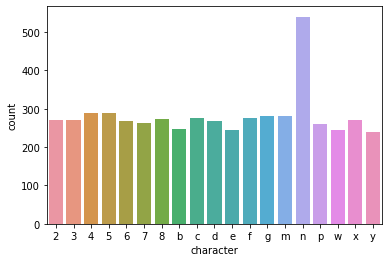

In [13]:
data = pd.DataFrame(df['char1'].value_counts() + df['char2'].value_counts()
                    + df['char3'].value_counts() + df['char4'].value_counts() + df['char5'].value_counts()).reset_index()

data.columns = ['character', 'count']

sns.barplot(data=data, x ='character', y='count')
plt.show()

Now, looking at the characters in the CAPTCHA images, one can notice that:
only 19 characters are used 2,3,4,5,6,7,8 and b,c,d,e,f,g,m,n,p,w,x,y
the frequency of each character is roughly the same with one exception : n is used twice often than other characters

## Creation of Training, Validation and Test sets

The training set should have 80% of the data, the validation set and training sets would have 10% each. 
X_train will have 856 images of the shape (856, 50, 200, 1)
y_train will have 856 images of the shape (856, 5) - 5 representing each of the characters

X_val and X_test will have 107 images each of the shape same as X_train
y_val and y_test will have 107 images each of the shape same as y_train

As Neural nets only deal with numeric values, we have to map each character in the char string to an integer

In [20]:
df.dtypes

filename     object
extension    object
label        object
labelsize    object
char1        object
char2        object
char3        object
char4        object
char5        object
dtype: object

In [21]:
# dictionary containing characters that needs to be converted to numeric

vocabulary = {'2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y'}

char_to_num = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, 'b': 7,
              'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'm': 13, 'n': 14, 'p':15,
              'w':16, 'x':17, 'y':18}


In [22]:
# This function encodes a single sample. 
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,14,6,12,12] for '6n6gg'

In [24]:
def encode_single_sample(img_path, label, crop):
    
    # reads image file and returns a tensor with dtype= string
    img = tf.io.read_file(img_path)
    
    # decode and converts to grayscale. Not losing any information
    img = tf.io.decode_png(img, channels=1)
    
    # scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # crops and resize to original size:
    # top-left corner = offset_height, offset_width in image = 0, 25
    # lower-right coner is at offset_height + target_height, offset_width + target_width =50, 150
    
    if (crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height = 50, target_width=125)
        img = tf.image.resize(img, size=[50, 200], method='bilinear', preserve_aspect_ratio=False,
                              antialias=False, name=None)
        
    # transpose the image because we want the time dimension to correspond with the width of the image
    img = tf.transpose(img, perm= [1, 0, 2])
    
    # convert label into an array with 5 integers
    label = list(map(lambda x: char_to_num[x], label))
    
    return img.numpy(), label


In [29]:
def split_dataset(crop=False):
    X, y = [], []
    
    for root, dirs, files in os.walk(folder):
        for f in files:
            # let's ignore the jpg files
            
            label = f.split('.')[0]
            extension = f.split('.')[1]
            
            if extension == 'png':
                img, label = encode_single_sample(folder + f, label, crop)
                X.append(img)
                y.append(label)
                
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, 
                                                      shuffle=True, random_state=42)
    X_train = X_train.reshape(936, 200, 50, 1)
    X_val = X_val.reshape(104, 200, 50, 1)
    
    return X_train, X_val, y_train, y_val

In [30]:
X_train, X_val, y_train, y_val = split_dataset(crop=True)
X_train_, X_val_, y_train_, y_val_ = split_dataset(crop=False)

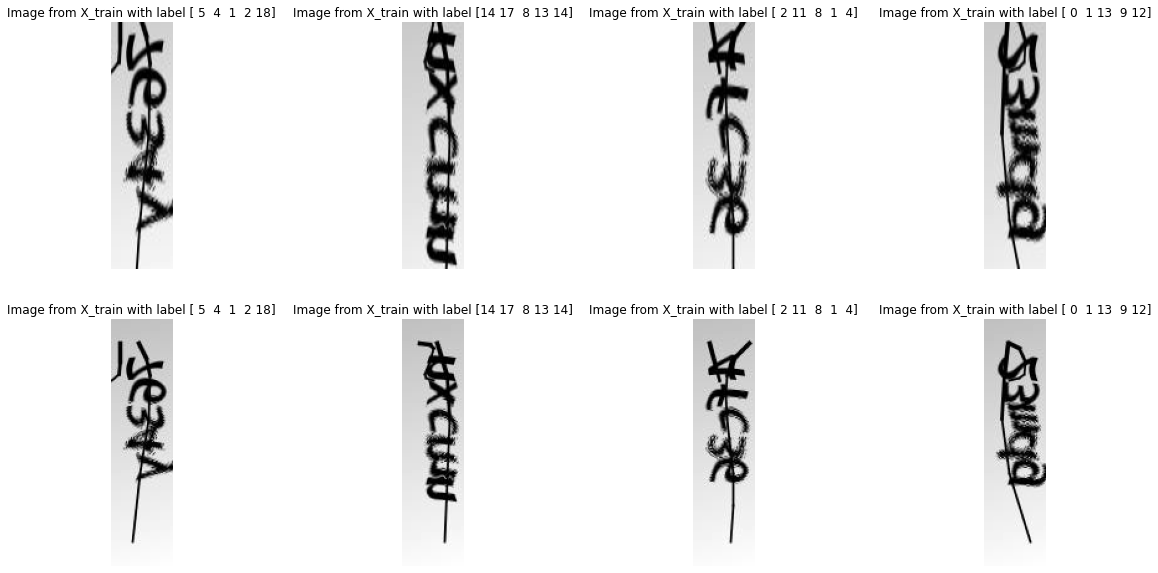

In [32]:
figure = plt.figure(figsize=(20, 10))

figure.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train[0]))
plt.axis('off')

figure.add_subplot(2, 4, 2)
plt.imshow(X_train[900], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train[900]))
plt.axis('off')

figure.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
plt.title('Image from X_train with label ' + str(y_val[0]))
plt.axis('off')

figure.add_subplot(2, 4, 4)
plt.imshow(X_val[103], cmap='gray')
plt.title('Image from X_train with label ' + str(y_val[103]))
plt.axis('off')

figure.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train_[0]))
plt.axis('off')

figure.add_subplot(2, 4, 6)
plt.imshow(X_train_[900], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train_[900]))
plt.axis('off')

figure.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Image from X_train with label ' + str(y_val_[0]))
plt.axis('off')

figure.add_subplot(2, 4, 8)
plt.imshow(X_val_[103], cmap='gray')
plt.title('Image from X_train with label ' + str(y_val_[103]))
plt.axis('off')

plt.show()

## ML Model

In [40]:
from keras import models
from keras import layers

input_img = layers.Input(shape=(200, 50, 1), dtype='float32')

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(200, 50, 1), 
                        dtype='float32', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# output volume shape = (50, 12, 64)

model.add(layers.Reshape(target_shape=(5, 7680)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# the output model should output 19 classes
model.add(layers.Dense(19, activation='softmax'))

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 25, 32)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 12, 64)       0         
 2D)                                                             
                                                                 
 reshape_2 (Reshape)         (None, 5, 7680)           0         
                                                                 
 dense (Dense)               (None, 5, 256)           

In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
history = model.fit(X_train, y_train, epochs=30, validation_data= (X_val, y_val))

Epoch 1/30
30/30 [==============================] - 12s 320ms/step - loss: 3.0978 - acc: 0.1212 - val_loss: 2.5607 - val_acc: 0.2346
Epoch 2/30
30/30 [==============================] - 9s 305ms/step - loss: 1.9018 - acc: 0.4447 - val_loss: 1.1708 - val_acc: 0.6712
Epoch 3/30
30/30 [==============================] - 9s 303ms/step - loss: 0.7610 - acc: 0.7885 - val_loss: 0.5479 - val_acc: 0.8288
Epoch 4/30
30/30 [==============================] - 9s 304ms/step - loss: 0.3926 - acc: 0.8885 - val_loss: 0.4047 - val_acc: 0.8788
Epoch 5/30
30/30 [==============================] - 9s 303ms/step - loss: 0.2970 - acc: 0.9109 - val_loss: 0.3639 - val_acc: 0.8731
Epoch 6/30
30/30 [==============================] - 10s 318ms/step - loss: 0.2045 - acc: 0.9385 - val_loss: 0.3032 - val_acc: 0.9077
Epoch 7/30
30/30 [==============================] - 10s 338ms/step - loss: 0.1453 - acc: 0.9581 - val_loss: 0.2813 - val_acc: 0.9096
Epoch 8/30
30/30 [==============================] - 9s 306ms/step - loss:

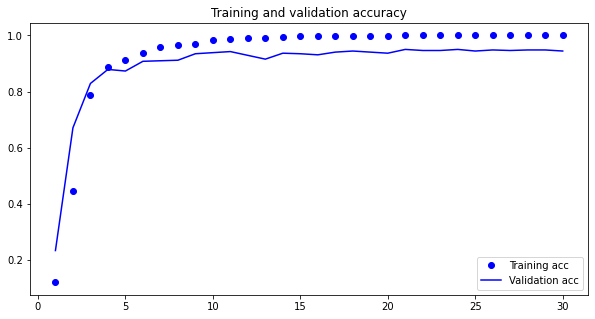

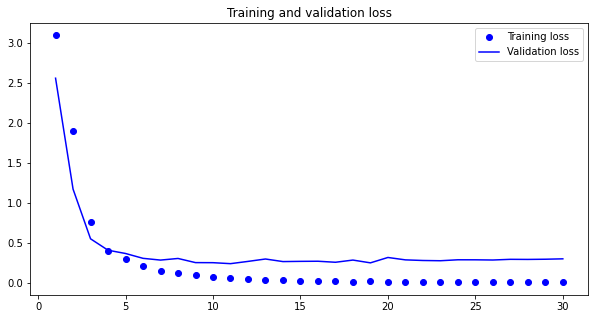

In [46]:
plt.figure(figsize=(10, 5))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
  
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
model.save('break_captcha.h5')

The model reached a validation of 94%

## Visualizing the Predictions

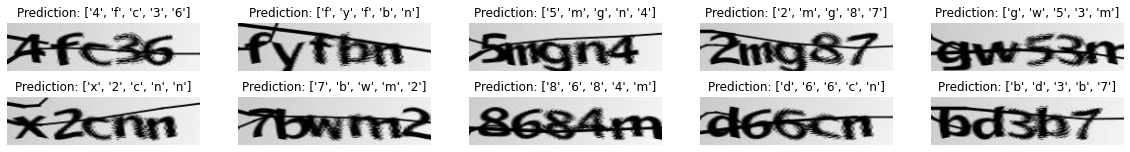

In [49]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d',
                    '10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}

nrow = 1
figure = plt.figure(figsize=(20,5))

for i in range(10):
    if i > 4:
        nrow = 2
    figure.add_subplot(nrow, 5, i + 1)
    plt.imshow(X_val[i].transpose((1, 0, 2)), cmap='gray')
    plt.title('Prediction: ' + str(list(map(lambda x: num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
    
plt.show()